In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.constants import N_A
import pints
from scipy.integrate import solve_ivp
import pints.plot
sns.set_context('talk')

In [67]:
Target_cell_number = 2e4
well_size = 50e-6
sigma = well_size*N_A/Target_cell_number
tumour_cell_radius = 7.25e-6
receptor_quant = {'500_F': 11902, 'MSX_B':1713701, '500_B':123366, '500_L':2831,
                  '250_A':124222, '250G_C': 91578, 'MSX_A': 1843343, 'MSX_C':1584638,
                  'MSX_D': 2158, 'MSX_E': 2478, 'MSX_F': 17469, '500_A': 120454,
                  '500_C': 107181, '500_D': 9824, '500_E': 6719, '500_H': 6341,
                  '500_I': 8195, '500_J': 7960, '500_K': 2174, 'MSX_I': 52886}
parameter_names=[r'$k_{on}$', r'$K_D$', r'$k_2$', 'C', 'noise1', 'noise2']
t_end = 60*60*1
t = np.geomspace(1e-10, t_end, 50)
tspan = [1e-10, t_end]

c_dict = {'500_B': 0.4465173849307427,
          '500_F': 0.8436671735015452,
          '500_L': 0.4785185291467099}

In [68]:
df = pd.read_excel(r'/Users/lukeheirene/ADCC-Project/GSK_mono_biv_project/Data/RE_ Mono vs Bivalent cell binding data - high affinity Ab/ELN354546_Tabular.xlsx')
#df = df.dropna(subset=['CELL_ID']).reset_index(drop=True)
df

,EXPERIMENT_ID,EXPERIMENT_TYPE,PLATE_ID,ROW,COLUMN,CELL_ID,ANTIBODY_ID,ANTIBODY_FORMAT,ANTIBODY_CONCENTRATION_MOLAR,RESPONSE
0,ELN354546,CELL_BINDING,1,A,1,MSX_A,28015,Bivalent,0.000001,1069337.0
1,ELN354546,CELL_BINDING,1,A,2,MSX_A,28015,Monovalent,0.000001,1605081.0
2,ELN354546,CELL_BINDING,1,A,3,MSX_A,28008,Bivalent,0.000001,891882.0
3,ELN354546,CELL_BINDING,1,A,4,MSX_A,28008,Monovalent,0.000001,1149507.0
4,ELN354546,CELL_BINDING,1,A,5,MSX_A,RSV,Bivalent,0.000001,24465.0
...,...,...,...,...,...,...,...,...,...,...
379,ELN354546,CELL_BINDING,1,P,20,500_L,RSV,Bivalent,0.000000,2069.0
380,ELN354546,CELL_BINDING,1,P,21,CHO_PARENT,28015,Bivalent,0.000000,2022.5
381,ELN354546,CELL_BINDING,1,P,22,CHO_PARENT,28015,Monovalent,0.000000,2172.0
382,ELN354546,CELL_BINDING,1,P,23,CHO_PARENT,28008,Bivalent,0.000000,2796.5


In [69]:
cell_ids = list(set(df['CELL_ID'].values))
cell_ids.remove('CHO_PARENT')
cell_ids.remove('MSX_A')
antibody_ids1 = list(set(df['ANTIBODY_ID'].values))
antibody_ids = [x for x in antibody_ids1 if str(x) != 'nan']
antibody_ids.remove('RSV')

def data_extractor(df, cell_id, antibody_id):

    df1 = df.query('CELL_ID==@cell_id & ANTIBODY_ID==@antibody_id')
    mono_df = df1.query('ANTIBODY_FORMAT=="Monovalent"')
    biv_df = df1.query('ANTIBODY_FORMAT=="Bivalent"')

    concs = list(np.flip(mono_df['ANTIBODY_CONCENTRATION_MOLAR'].values))
    response_mono = list(np.flip(mono_df['RESPONSE'].values))
    response_biv = list(np.flip(biv_df['RESPONSE'].values))
    return response_mono, response_biv, concs

In [70]:
def model_eqns(t, z, kon, KD, k2, rtot, Ainit):
    Atot = Ainit*sigma
    k1 = kon/sigma
    A0 = Atot - z[0] - z[1]
    r = rtot - z[0] - 2*z[1]

    dA1 = 2*k1*r*A0 - (KD*kon)*z[0] - k2*r*z[0] + 2*(KD*kon)*z[1]
    dA2 = k2*z[0]*r - 2*(KD*kon)*z[1]

    return [dA1, dA2]


def solve_model_individual(kon, KD, k2, rtot, A0s):
    solution = np.zeros_like(A0s)
    z0 = [0, 0]
    for i, Ainit in enumerate(A0s):
        z = solve_ivp(model_eqns, tspan, z0, method='Radau', t_eval=t, args=(kon, KD, k2, rtot, Ainit))
        A1 = z.y[0]
        A2 = z.y[1]
        bound_ab = A1[-1] + A2[-1]
        solution[i] = bound_ab
    
    return solution

def simulate_model(A0s, parameters, rtot, C):

    kon = parameters[0]
    kon = 10**kon
    KD = parameters[1]
    KD = 10**KD
    k2 = parameters[2]
    k2 = 10**k2
    #C = parameters[3]
    solution = np.zeros((len(A0s), 2))
    solution[:, 0] = (solve_model_individual(kon, KD, 0, rtot, A0s))
    solution[:, 1] = (solve_model_individual(kon, KD, k2, rtot, A0s))

    return C*solution 


In [71]:
def mcmc_alg(cell_id, antibody_id, conc_data, mono_data, biv_data, c, max):
    
    #setup data
    data = np.stack((mono_data, biv_data), axis=1)
    rtot = receptor_quant[cell_id]
    

    #remove cho cell measured background from expression
    rtot = rtot - 2000
    data = data/max
    
    class model(pints.ForwardModel):

        def n_outputs(self):
         return 2
    
        def n_parameters(self):
         return 3
    
        def simulate(self, parameters, A0s):
         sim = simulate_model(A0s, parameters, rtot, c) 
         return sim/rtot
        

    #setup prior and posteriors
    mod = model()
    problem = pints.MultiOutputProblem(mod, conc_data, data)
    log_likelihood = pints.GaussianLogLikelihood(problem)
    parameters = [5.2, -8, -3,  0.2, 0.2]
    log_prior = pints.UniformLogPrior(
    [4, -12, -8, 0.01, 0.01],
    [6, -6, -0.5, 1, 1]
    )
    log_posterior = pints.LogPosterior(log_likelihood, log_prior)

    #setup mcmc
    xs = [
        np.array(parameters) * 0.85,
        np.array(parameters) * 0.95,
        np.array(parameters) * 1.05,
        np.array(parameters) * 1.15 
        ]
    mcmc = pints.MCMCController(log_posterior, 4, xs)
    mcmc.set_max_iterations(15000)
    chains = mcmc.run()

    chain = chains[0]
    chain = chain[10000:]
    chains1 = chains[:, 10000 :]
    fig, axes = pints.plot.series(chains1[0], problem)

    plt.legend()
    plt.xscale('log')
    plt.xlabel(r'Antibody Concentration')
    parameter_names=[r'$k_{on}$', r'$K_D$', r'$k_2$', 'noise1', 'noise2']
    results = pints.MCMCSummary(chains=chains1, time=mcmc.time(),parameter_names=parameter_names)
    print(results)

    return chains, results   

In [72]:
monos = []
bivs = []
concs = []

for cell_id in cell_ids:
    print(cell_id)
    rsv = 'RSV'
    df2 = df.query('CELL_ID==@cell_id & ANTIBODY_ID==@rsv')
    subtract = df2['RESPONSE'].values
    subtract = np.array(subtract[:-1])
    c = c_dict[cell_id]

    mono_med, biv_med, conc = data_extractor(df, cell_id, 28008)
    mono_high, biv_high, conc = data_extractor(df, cell_id, 28015)

    mono_med = np.array(mono_med[:-1])
    biv_med = np.array(biv_med[:-1])
    conc = np.array(conc[:-1])
    mono_med = mono_med - subtract
    biv_med = biv_med-subtract
    for i in range(len(mono_med)):
        if mono_med[i]<0:
            mono_med[i]= 1e-4
        if biv_med[i]<0:
            biv_med[i]=1e-4

    mono_high = np.array(mono_high[:-1])
    biv_high = np.array(biv_high[:-1])
    mono_high = mono_high - subtract
    biv_high = biv_high-subtract
    for i in range(len(mono_high)):
        if mono_high[i]<0:
            mono_high[i]= 1e-4
        if biv_high[i]<0:
            biv_high[i]=1e-4

    rtot = receptor_quant[cell_id] - 2000

    max = np.max((mono_high, biv_high))


    
    antibody_id = 28008
    chain_results, results = mcmc_alg(cell_id, antibody_id, conc, mono_med, biv_med, c, max)
        
    #plot chains
    parameter_names=[r'$k_{on}$', r'$K_D$', r'$k_2$', 'noise1', 'noise2']
    pints.plot.trace(chain_results, parameter_names=parameter_names) 
    name = str(cell_id) + str(antibody_id)
    chains_filename = '/Users/lukeheirene/ADCC-Project/GSK_mono_biv_project/ELN354546_Plots/renormalised_chains_%s.png' % name
    plt.tight_layout()
    plt.savefig(chains_filename)


    chain = chain_results[0]
    chain = chain[10000:]
    chains1 = chain_results[:, 10000 :]
    pints.plot.pairwise(chain, kde=True,  parameter_names=parameter_names)
    posteriors_filename = '/Users/lukeheirene/ADCC-Project/GSK_mono_biv_project/ELN354546_Plots/renormalised_posteriors_%s.png' % name
    plt.tight_layout()
    plt.savefig(posteriors_filename)

    results_list = results._summary_list
    results_dic = {}
    means =[]
    stds = []
    l_perc = []
    h_perc = []
    rhats = []
    parameter_names1=[r'$k_{on}$', r'$K_D$', r'$k_2$']
    for i, param in enumerate(parameter_names1):
        holder = results_list[i]
        means.append(holder[1])
        stds.append(holder[2])
        l_perc.append(holder[3])
        h_perc.append(holder[7])
        rhats.append(holder[8])

    results_dic['parameter'] = parameter_names1
    results_dic['mean'] = means
    results_dic['std'] = stds
    results_dic['2.5%'] = l_perc
    results_dic['97.5%'] = h_perc
    results_dic['rhat'] = rhats

    df_new = pd.DataFrame(results_dic)
    csv_name = posteriors_filename = '/Users/lukeheirene/ADCC-Project/GSK_mono_biv_project/ELN354546_results/renormalised_results_%s.csv' % name
    df_new.to_csv(csv_name)

    sim = simulate_model(conc, results_dic['mean'], rtot, c)
    fig, ax = plt.subplots()
    ax.semilogx(conc, sim[:, 0]*max/rtot, label='monovalent fit', c='red')
    ax.semilogx(conc, sim[:, 1]*max/rtot, label = 'bivalent fit', c='blue')
    ax.scatter(conc, mono_med, label='monovalent data', c='red')
    ax.scatter(conc, biv_med, label='bivalent data', c='blue')
    ax.legend(loc='best')
    ax.set_ylabel('Response')
    ax.set_xlabel('Antibody Concentration (M)')
    ax.set_title('cell: ' + str(cell_id) + ', ' + 'Ab: ' + str(antibody_id))
    filename = '/Users/lukeheirene/ADCC-Project/GSK_mono_biv_project/ELN354546_Plots/renormalised_fitting_results%s.png' % name
    fig.tight_layout()
    fig.savefig(filename)


500_F
Using Haario-Bardenet adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.3
1     8      0         0.5       0         0.5        0:00.5
2     12     0         0.667     0         0.333      0:00.7
3     16     0.25      0.75      0         0.5        0:01.0
20    84     0.429     0.333     0.381     0.429      0:04.9
40    164    0.341     0.293     0.293     0.39       0:09.5
60    244    0.344     0.23      0.23      0.279      0:13.4
80    324    0.358     0.235     0.173     0.259      0:17.4
100   404    0.317     0.238     0.139     0.208      0:21.0
120   484    0.289     0.214876  0.116     0.19       0:25.0
140   564    0.262     0.227     0.106383  0.184      0:28.4
160   644    0.236     0.242236  0.106     0.173913   0:32.2
180   724    0.21      0.254     0.121547  0.160221   0:36.2
Initial phase completed.
200   804    0.1990

KeyboardInterrupt: 

Text(0.5, 0, 'Antibody Concentration (M)')

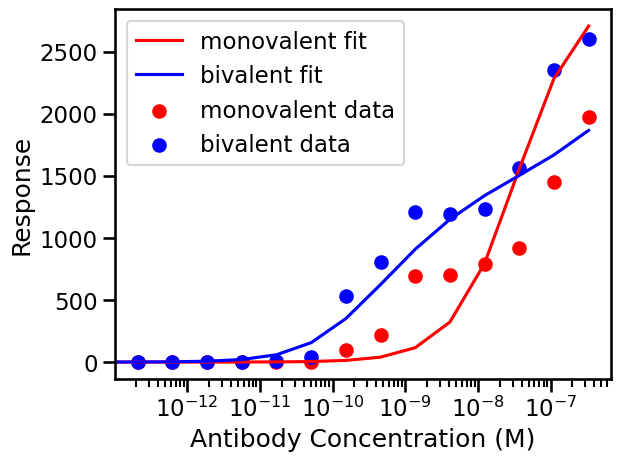

In [ ]:
sim = simulate_model(conc, results_dic['mean'], rtot, c)
fig, ax = plt.subplots()
ax.semilogx(conc, sim[:, 0]*max/rtot, label='monovalent fit', c='red')
ax.semilogx(conc, sim[:, 1]*max/rtot, label = 'bivalent fit', c='blue')
ax.scatter(conc, mono_med, label='monovalent data', c='red')
ax.scatter(conc, biv_med, label='bivalent data', c='blue')
ax.legend(loc='best')
ax.set_ylabel('Response')
ax.set_xlabel('Antibody Concentration (M)')